# Importando as bibliotecas

In [ ]:
import cv2
import numpy as np
from keras import layers, metrics, losses, optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import seaborn as sns
import pandas as pd
import hashlib
import math as mt
import os


IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 100
classes = ['PNEUMONIA', 'COVID19', 'TUBERCULOSE', 'NORMAL']
dataset_path = '/content/drive/MyDrive/d.IAgnostica - Livros/Classificação Pneumonia+COVID19+Tuberculose/Dataset'
dataset_path_train = os.path.join(dataset_path, 'train')
dataset_path_test = os.path.join(dataset_path, 'test')
dataset_path_val = os.path.join(dataset_path, 'val')
dia = str(datetime.date.today())

# Baixando o dataset

In [ ]:
os.makedirs('/content/data/COVID19-PNEUMONIA')
data_dir = '/content/data'
os.environ['KAGGLE_CONFIG_DIR'] = '/content/data'

1 - Imbalanced Tuberculosis and Pneumonia dataset

In [ ]:
!kaggle datasets download -d roshanmaur/imbalanced-tuberculosis-and-pnuemonia-dataset

100% 5.86G/5.87G [00:48<00:00, 164MB/s]
100% 5.87G/5.87G [00:48<00:00, 130MB/s]


2 - COVID19+PNEUMONIA+NORMAL Chest X-Ray Image Dataset

In [ ]:
!kaggle datasets download -d sachinkumar413/covid-pneumonia-normal-chest-xray-images

 94% 262M/277M [00:02<00:00, 116MB/s]
100% 277M/277M [00:02<00:00, 115MB/s]


3 - Chest X-Ray Images (Pneumonia)

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:13<00:00, 163MB/s]
100% 2.29G/2.29G [00:13<00:00, 181MB/s]


Descompactando dataset's

In [ ]:
!unzip /content/imbalanced-tuberculosis-and-pnuemonia-dataset.zip -d /content/data
!unzip /content/chest-xray-pneumonia.zip -d /content/data
!unzip /content/covid-pneumonia-normal-chest-xray-images.zip -d /content/data/COVID19-PNEUMONIA

# Salvando e dividindo as imagens






Definindo os diretórios das imagens de cada classe

In [ ]:
dataset1_dir = os.path.join(data_dir, 'COVID19-PNEUMONIA')
dataset2_dir = os.path.join(data_dir, 'all_images')
dataset3_dir = os.path.join(data_dir, 'chest_xray')

pneumonia_dir = [
    '/content/data/COVID19-PNEUMONIA/PNEUMONIA',
    '/content/data/all_images/Pneumonia',
    '/content/data/all_images/universal_test/Pneumonia',
    '/content/data/chest_xray/test/PNEUMONIA',
    '/content/data/chest_xray/train/PNEUMONIA',
    '/content/data/chest_xray/val/PNEUMONIA',
]

covid19_dir = [
    '/content/data/COVID19-PNEUMONIA/COVID',
]

tuberculose_dir = [
    '/content/data/all_images/Tuberculosis',
    '/content/data/all_images/universal_test/Tuberculosis',
]

normal_dir = [
    '/content/data/chest_xray/test/NORMAL',
    '/content/data/chest_xray/train/NORMAL',
    '/content/data/chest_xray/val/NORMAL',
    '/content/data/COVID19-PNEUMONIA/NORMAL',
    '/content/data/all_images/Normal',
    '/content/data/all_images/universal_test/Normal',
]

data = [
    (pneumonia_dir, classes[0]),
    (covid19_dir, classes[1]),
    (tuberculose_dir, classes[2]),
    (normal_dir, classes[3]),
]

Criando a função para carregar as imagens, desconsiderando as dúplicas

In [ ]:
def getDataFrom(dir_names: tuple) -> list[tuple]:
  data:list[tuple] = list()
  label = classes.index(dir_names[1])
  hash_map = set()
  count_dupli = 0

  for path in dir_names[0]:
    for img in os.listdir(path):
      with open(os.path.join(path, img), 'rb') as f:
        img_hash = hashlib.sha256(f.read()).hexdigest()

      if img_hash not in hash_map:
        hash_map.add(img_hash)
        try:
          img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
          #resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
          data.append((img_arr, label))
        except Exception as e:
          print('Erro: ', e)
      else:
        count_dupli += 1
  print(f'{dir_names[1]:^13} duplicadas: {count_dupli}')
  return data

Carregando as imagens

In [ ]:
pneumonia = getDataFrom(data[0])
covid19 = getDataFrom(data[1])
tuberculose = getDataFrom(data[2])
normal = getDataFrom(data[3])

  PNEUMONIA   duplicadas: 4282
   COVID19    duplicadas: 89
 TUBERCULOSE  duplicadas: 0
   NORMAL     duplicadas: 1650


Criando listas que armazenam totas as imagens e classes

In [ ]:
features = []
labels = []

for feature, label in pneumonia:
  features.append(feature)
  labels.append(label)

for feature, label in covid19:
  features.append(feature)
  labels.append(label)

for feature, label in tuberculose:
  features.append(feature)
  labels.append(label)

for feature, label in normal:
  features.append(feature)
  labels.append(label)

features = np.array(features)
labels = np.array(labels)

<ipython-input-11-7905fececca0>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  features = np.array(features)


Dividindo as imagens para treino, teste e validação

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=.15, random_state=1)

per_val = round((.15 * len(features)) / y_train.shape[0], ndigits=4)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=per_val, random_state=1)

Criando os diretórios necessários

In [ ]:
for classe in classes:
  os.mkdir(os.path.join(dataset_path_train, classe))
  os.mkdir(os.path.join(dataset_path_test, classe))
  os.mkdir(os.path.join(dataset_path_val, classe))

Salvando as imagens de treino, teste e validação em pastas separadas

In [ ]:
for i in range(len(x_train)):
  path = os.path.join(dataset_path_train, classes[y_train[i]])
  r = cv2.imwrite(os.path.join(path, f'img-train-{i}-{classes[y_train[i]]}.png'), x_train[i])
  if not r: print(r)

for i in range(len(x_test)):
  path = os.path.join(dataset_path_test, classes[y_test[i]])
  r = cv2.imwrite(os.path.join(path, f'img-test-{i}-{classes[y_test[i]]}.png'), x_test[i])
  if not r: print(r)

for i in range(len(x_val)):
  path = os.path.join(dataset_path_val, classes[y_val[i]])
  r = cv2.imwrite(os.path.join(path, f'img-val-{i}-{classes[y_val[i]]}.png'), x_val[i])
  if not r: print(r)

Visualizando a divisão das imagens

In [ ]:
train_div = {classe: 0 for classe in classes}
test_div = {classe: 0 for classe in classes}
val_div = {classe: 0 for classe in classes}

for classe in classes:
  for label in os.listdir(os.path.join(dataset_path_train, classe)):
    train_div[classe] += 1

for classe in classes:
  for label in os.listdir(os.path.join(dataset_path_test, classe)):
    test_div[classe] += 1

for classe in classes:
  for label in os.listdir(os.path.join(dataset_path_val, classe)):
    val_div[classe] += 1

print(f'Imagens Para Treino: {sum(train_div.values())}')
print(train_div)
print(f'Imagens Para Teste: {sum(test_div.values())}')
print(test_div)
print(f'Imagens Para Validação: {sum(val_div.values())}')
print(val_div)

Imagens Para Treino: 14337
{'PNEUMONIA': 4197, 'COVID19': 1070, 'TUBERCULOSE': 1323, 'NORMAL': 7747}
Imagens Para Teste: 3073
{'PNEUMONIA': 919, 'COVID19': 222, 'TUBERCULOSE': 284, 'NORMAL': 1648}
Imagens Para Validação: 3074
{'PNEUMONIA': 920, 'COVID19': 245, 'TUBERCULOSE': 281, 'NORMAL': 1628}


# Explorandos os dados

Função para carregar os dados para memória

In [ ]:
def getDataFrom(dir_name: str, transformations:list=[]) -> list[tuple]:
  data:list[tuple] = list()
  for classe in classes:
    path = os.path.join(dir_name, classe)
    class_num = classes.index(classe)
    for img in os.listdir(path):
      try:
        img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        resize_img = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
        for transformation in transformations:
          if transformation == 'equalize':
            resize_img = cv2.equalizeHist(resize_img) # Equalização de Histograma
          elif transformation == 'gaussian':
            resize_img = cv2.GaussianBlur(resize_img, (3, 3), 0) # Filtro gaussiano
          elif transformation == 'median':
            resize_img = cv2.medianBlur(resize_img, 3)
          elif transformation == 'avarage':
            resize_img = cv2.blur(resize_img, (3, 3))
          elif transformation == 'contrast':
            resize_img = cv2.convertScaleAbs(resize_img, alpha=1.3, beta=0)
        data.append((resize_img, class_num))
      except Exception as e:
        print('Erro: ', e)
  return data

Carregando os dados

In [ ]:
transformations = []
transformations.append('equalize')
#transformations.append('contrast')
#transformations.append('gaussian')
#transformations.append('median')
#transformations.append('avarage')

train = getDataFrom(dataset_path_train, transformations)
test = getDataFrom(dataset_path_test, transformations)
val = getDataFrom(dataset_path_val, transformations)

Normalizando as imagens

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

# resize data for deep learning
x_train = x_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = np.array(y_test)

# Data augmentation

In [ ]:
datagen = ImageDataGenerator(zoom_range=0.2)
datagen.fit(x_train)

# Definindo as camadas do modelo

In [ ]:
model = Sequential()
model.add(layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(layers.Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(layers.Dropout(0.1))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(layers.Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(layers.Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(layers.Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(layers.Flatten())
model.add(layers.Dense(units = 256 , activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=4))

loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam' , loss=loss , metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 224, 224, 64)      640       
                                                                 
 batch_normalization_5 (Bat  (None, 224, 224, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 dropout_4 (Dropout)         (None, 112, 112, 128)     0         
                                                                 
 batch_normalization_6 (Bat  (None, 112, 112, 128)    

# Treinando o modelo

In [14]:
FILE_PATH = '/content/drive/MyDrive/d.IAgnostica - Livros/Classificação Pneumonia+COVID19+Tuberculose/modelos/model-{epoch:02d}-{val_accuracy:.4f}-'+dia+'.h5'

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.3,
                                            min_lr=0.000001)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               verbose=1,
                               restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath=FILE_PATH,
                             monitor='val_accuracy')

steps_per_epoch = mt.ceil(x_train.shape[0] / BATCH_SIZE)

history = model.fit(x_train, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_val, y_val),
                    callbacks = [learning_rate_reduction, early_stopping, checkpoint],
                    steps_per_epoch=steps_per_epoch)

Epoch 1/100
449/449 [==============================] - 116s 251ms/step - loss: 0.5610 - accuracy: 0.8412 - val_loss: 2.0010 - val_accuracy: 0.4372 - lr: 0.0010
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


449/449 [==============================] - 111s 248ms/step - loss: 0.2944 - accuracy: 0.8941 - val_loss: 0.3578 - val_accuracy: 0.8761 - lr: 0.0010
Epoch 3/100
449/449 [==============================] - 110s 246ms/step - loss: 0.2295 - accuracy: 0.9173 - val_loss: 0.6822 - val_accuracy: 0.8159 - lr: 0.0010
Epoch 4/100
449/449 [==============================] - 109s 244ms/step - loss: 0.2025 - accuracy: 0.9266 - val_loss: 0.1846 - val_accuracy: 0.9382 - lr: 0.0010
Epoch 5/100
449/449 [==============================] - 110s 245ms/step - loss: 0.1750 - accuracy: 0.9372 - val_loss: 0.2564 - val_accuracy: 0.8979 - lr: 0.0010
Epoch 6/100
448/449 [============================>.] - ETA: 0s - loss: 0.1544 - accuracy: 0.9449
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
449/449 [==============================] - 109s 244ms/step - loss: 0.1544 - accuracy: 0.9449 - val_loss: 0.2766 - val_accuracy: 0.9089 - lr: 0.0010
Epoch 7/100
449/449 [==============================

# Testando os modelos gerados

Funções para testar todos os modelos

In [15]:
def result_class(predictions: list) -> list:
  class_predictions = []
  for prediction in predictions:
    class_predictions.append(np.argmax(prediction))
  return class_predictions

def testarModelos_aux(dir: str, imgs_teste: list, labels_teste: list) -> list[dict]:
  models_metrics = dict()
  for model_name in os.listdir(dir):
    if '.h5' in model_name:
      model_path = os.path.join(dir, model_name)
      model = load_model(model_path)

      predictions = model.predict(imgs_teste)
      class_predictions = result_class(predictions)

      models_metrics[model_name] = classification_report(labels_teste, class_predictions, digits=4, target_names=classes, output_dict=True)
      models_metrics[model_name]['kappa'] = cohen_kappa_score(labels_teste, class_predictions)
  return models_metrics

def testarModelos(dir: str, imgs_teste: list, labels_teste: list) -> list[dict]:
  models_metrics_root = testarModelos_aux(dir, imgs_teste, labels_teste)
  models_metrics = dict()

  for model in models_metrics_root:
    models_metrics[model] = dict()

    models_metrics[model]['acuracia'] = models_metrics_root[model]['accuracy']
    models_metrics[model]['f1-score'] = models_metrics_root[model]['macro avg']['f1-score']
    models_metrics[model]['recall'] = models_metrics_root[model]['macro avg']['recall']
    models_metrics[model]['precision'] = models_metrics_root[model]['macro avg']['precision']
    models_metrics[model]['kappa'] = models_metrics_root[model]['kappa']
  return models_metrics


Testando todos os modelos

In [32]:
dir = '/content/drive/MyDrive/d.IAgnostica - Livros/Classificação Pneumonia+COVID19+Tuberculose/modelos'
models_metrics = testarModelos(dir, x_test, y_test)

97/97 [==============================] - 6s 64ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


97/97 [==============================] - 3s 30ms/step


Mostrando as métricas dos modelos

In [33]:
primeiro = True
for modelo in models_metrics:
  if primeiro:
    print('{:^27}'.format('modelo'), end='')
    for key in models_metrics[modelo]:
      print(f'{key:^27}', end='')
    print()
    primeiro = False

  if models_metrics[modelo]['f1-score'] >= .94:
    print(f'{modelo:^25}', end='')
    for key in models_metrics[modelo]:
      metric = models_metrics[modelo][key]
      print(f'{metric:^27.4f}'.replace('.', ','), end='')
    print()

          modelo                    acuracia                   f1-score                    recall                    precision                    kappa           
model-16-0.9688-2023-11-20.h5          0,9665                     0,9455                     0,9349                     0,9569                     0,9446           


In [ ]:
MODEL_PATH = '/content/drive/MyDrive/d.IAgnostica - Livros/Classificação Pneumonia+COVID19+Tuberculose/modelos/2023-11-13/model-14-0.9645-07112023.h5'
trainModel = load_model(MODEL_PATH)
#trainModel.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=1)

In [ ]:
predictions = trainModel.predict(x_test)

predict_class = []
for p in predictions:
  predict_class.append(np.argmax(p))

97/97 [==============================] - 2s 15ms/step


In [ ]:
cm = confusion_matrix(y_test, predict_class)
print(cm)
report = classification_report(y_test, predict_class, digits=4, target_names=classes)
print(report)
kappa = cohen_kappa_score(y_test, predict_class)
print(f'Kappa Score: {kappa}')

[[ 907    3    0    9]
 [   4  207    6    5]
 [   3    4  252   25]
 [  15   13   11 1609]]
              precision    recall  f1-score   support

   PNEUMONIA     0.9763    0.9869    0.9816       919
     COVID19     0.9119    0.9324    0.9220       222
 TUBERCULOSE     0.9368    0.8873    0.9114       284
      NORMAL     0.9763    0.9763    0.9763      1648

    accuracy                         0.9681      3073
   macro avg     0.9503    0.9458    0.9478      3073
weighted avg     0.9680    0.9681    0.9680      3073

Kappa Score: 0.9475969934315709


<Axes: >

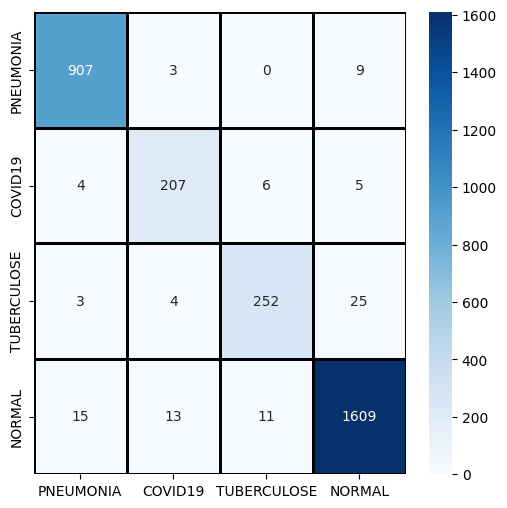

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1', '2', '3'] , columns = ['0','1', '2', '3'])
plt.figure(figsize = (6,6))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = classes,yticklabels = classes)